# Air pollution GRU and LSTM model

In [1]:
import os
import pandas as pd
import numpy as np
# PyTorch
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# Ray
import ray
from ray import tune
from ray.train.torch import enable_reproducibility
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.pytorch_lightning import TuneReportCheckpointCallback
# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# Visualization
import seaborn as sn
sn.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Plot the loss curve based on the latest file from lightning logs
def plot_loss_curve():
    latest_file = os.path.join(max([os.path.join("/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/lightning_logs", f) 
                                    for f in os.listdir("lightning_logs")], 
                                    key=os.path.getctime), "metrics.csv")
    loss_data = pd.read_csv(latest_file)
    loss_data['val_loss'] = loss_data.val_loss.shift(1)
    loss_data = loss_data[["epoch", "train_loss", "val_loss"]].dropna()
    loss_data['epoch'] = loss_data.epoch.map(lambda x: x+1)

    plt.plot(loss_data['epoch'], loss_data['train_loss'], label="Training loss")
    plt.plot(loss_data['epoch'], loss_data['val_loss'], label = "Validation loss")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss metric")
    plt.xticks(loss_data['epoch'])
    plt.legend(loc="upper right")
    plt.show()

## Exploring the dataset

In [3]:
pollution_df  = pd.read_csv("data/LSTM-Multivariate_pollution.csv")
pollution_test_df  = pd.read_csv("data/pollution_test_data1.csv")

In [81]:
pollution_df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [82]:
pollution_df.shape

(43800, 9)

In [83]:
pollution_df.dtypes

date          object
pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [84]:
pollution_df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [34]:
pollution_df.groupby("wnd_dir").wnd_dir.count()

wnd_dir
NE     4996
NW    14130
SE    15290
cv     9384
Name: wnd_dir, dtype: int64

In [27]:
pollution_df.isna().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

## Visualization

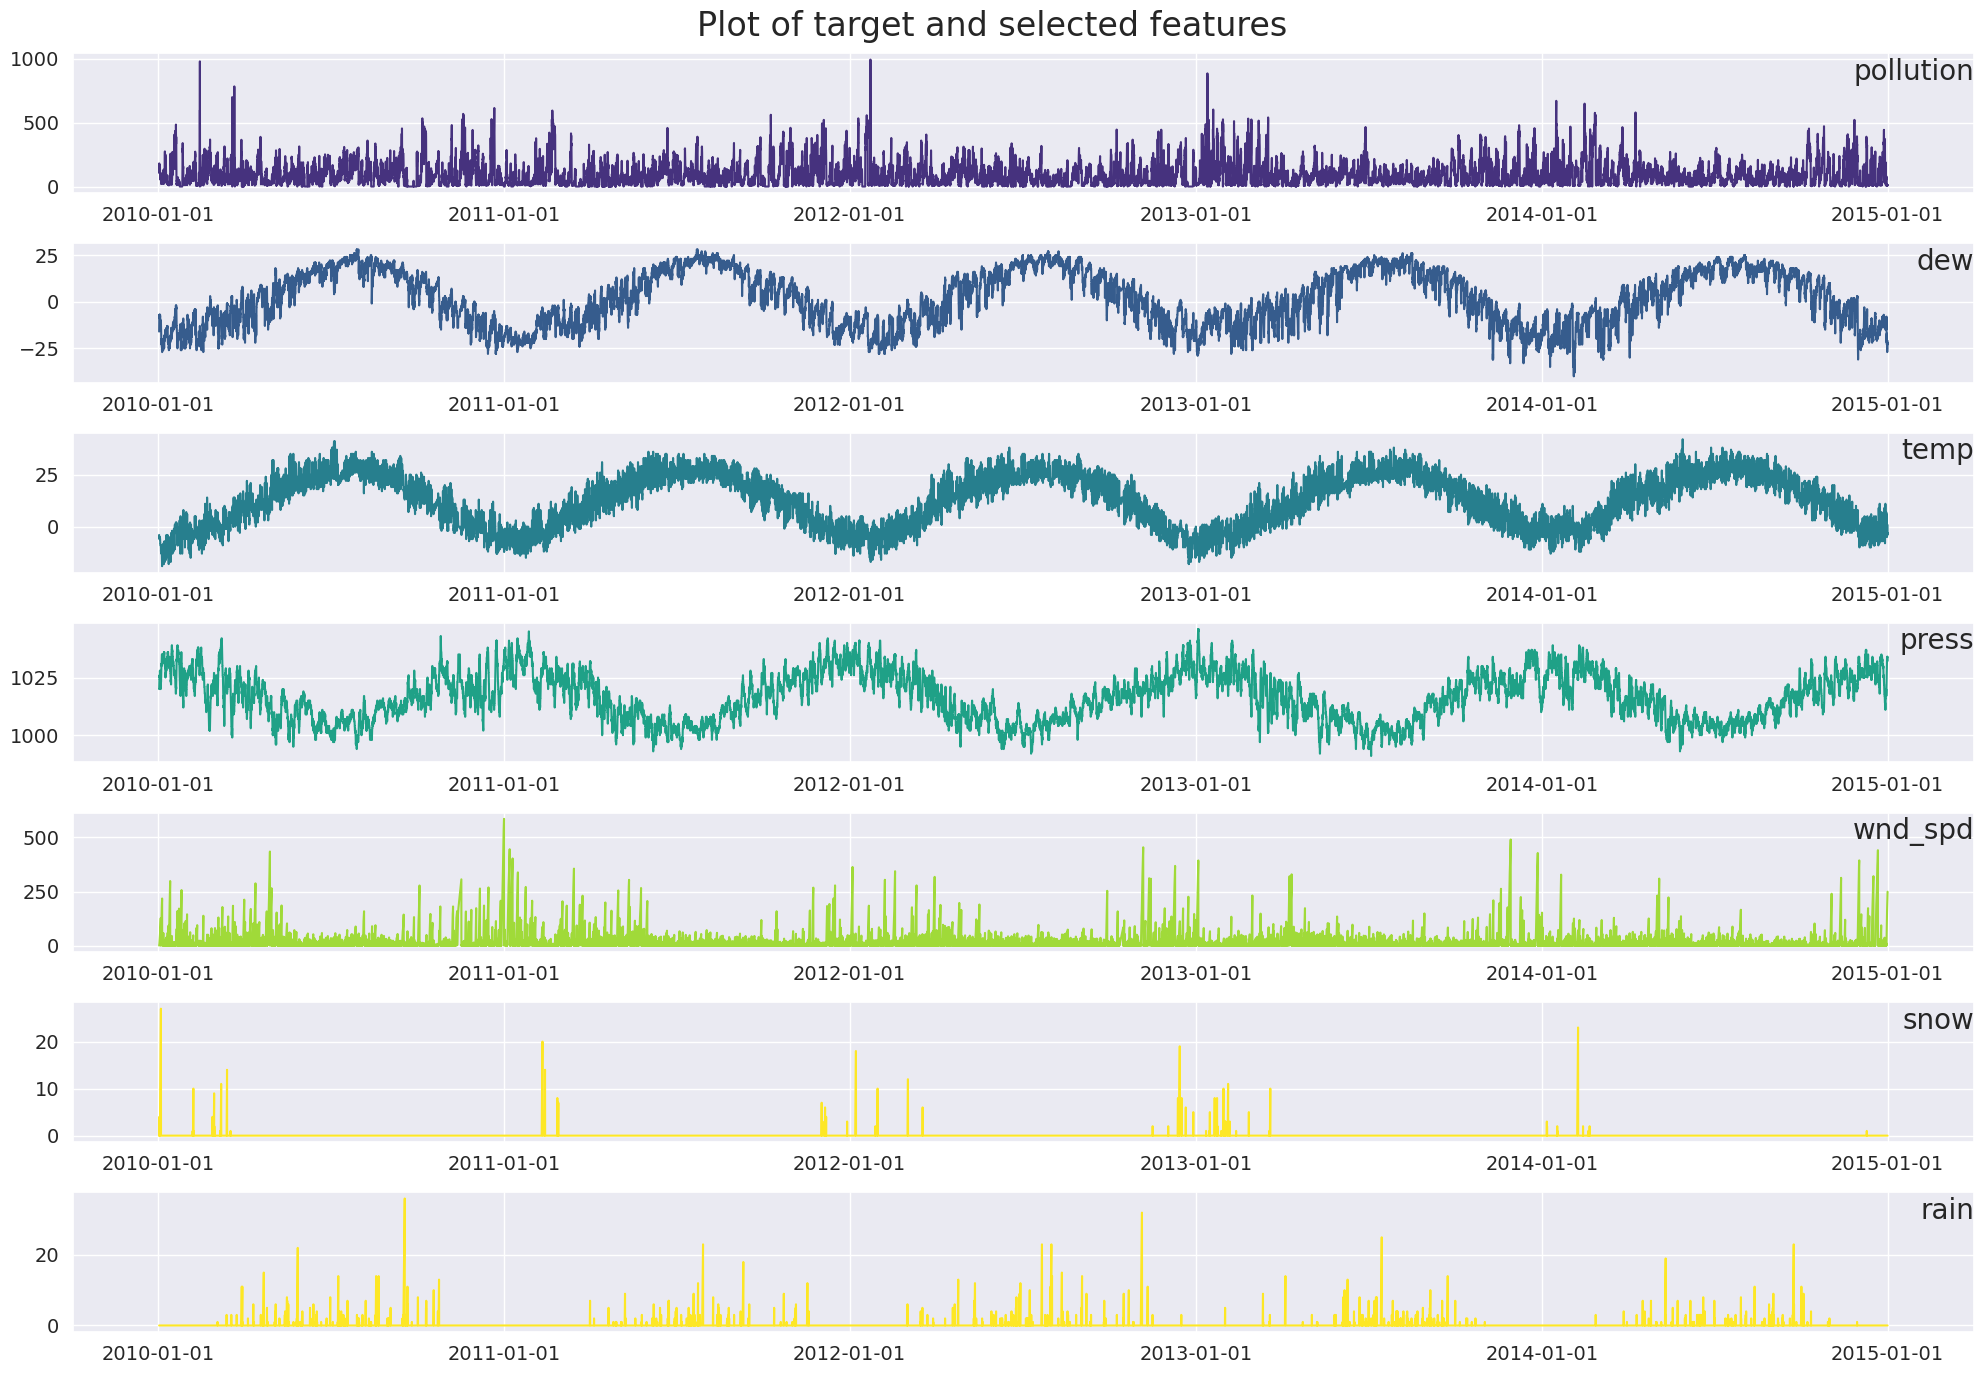

In [4]:
# Visualizing the numerical values
values = pollution_df.values
dates = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') for date_str in values[:,0]]

groups = [1, 2, 3, 4, 6, 7, 8]
i = 1

fig, axs = plt.subplots(len(groups), 1, figsize=(20, 14), facecolor='white')
for group, ax in zip(groups, axs):
    ax.plot(dates, values[:, group], color=cm.viridis(group/len(groups)))
    ax.set_title(pollution_df.columns[group], y=0.75, loc='right', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    i += 1

plt.suptitle('Plot of target and selected features', fontsize=24)
plt.tight_layout()
plt.show()

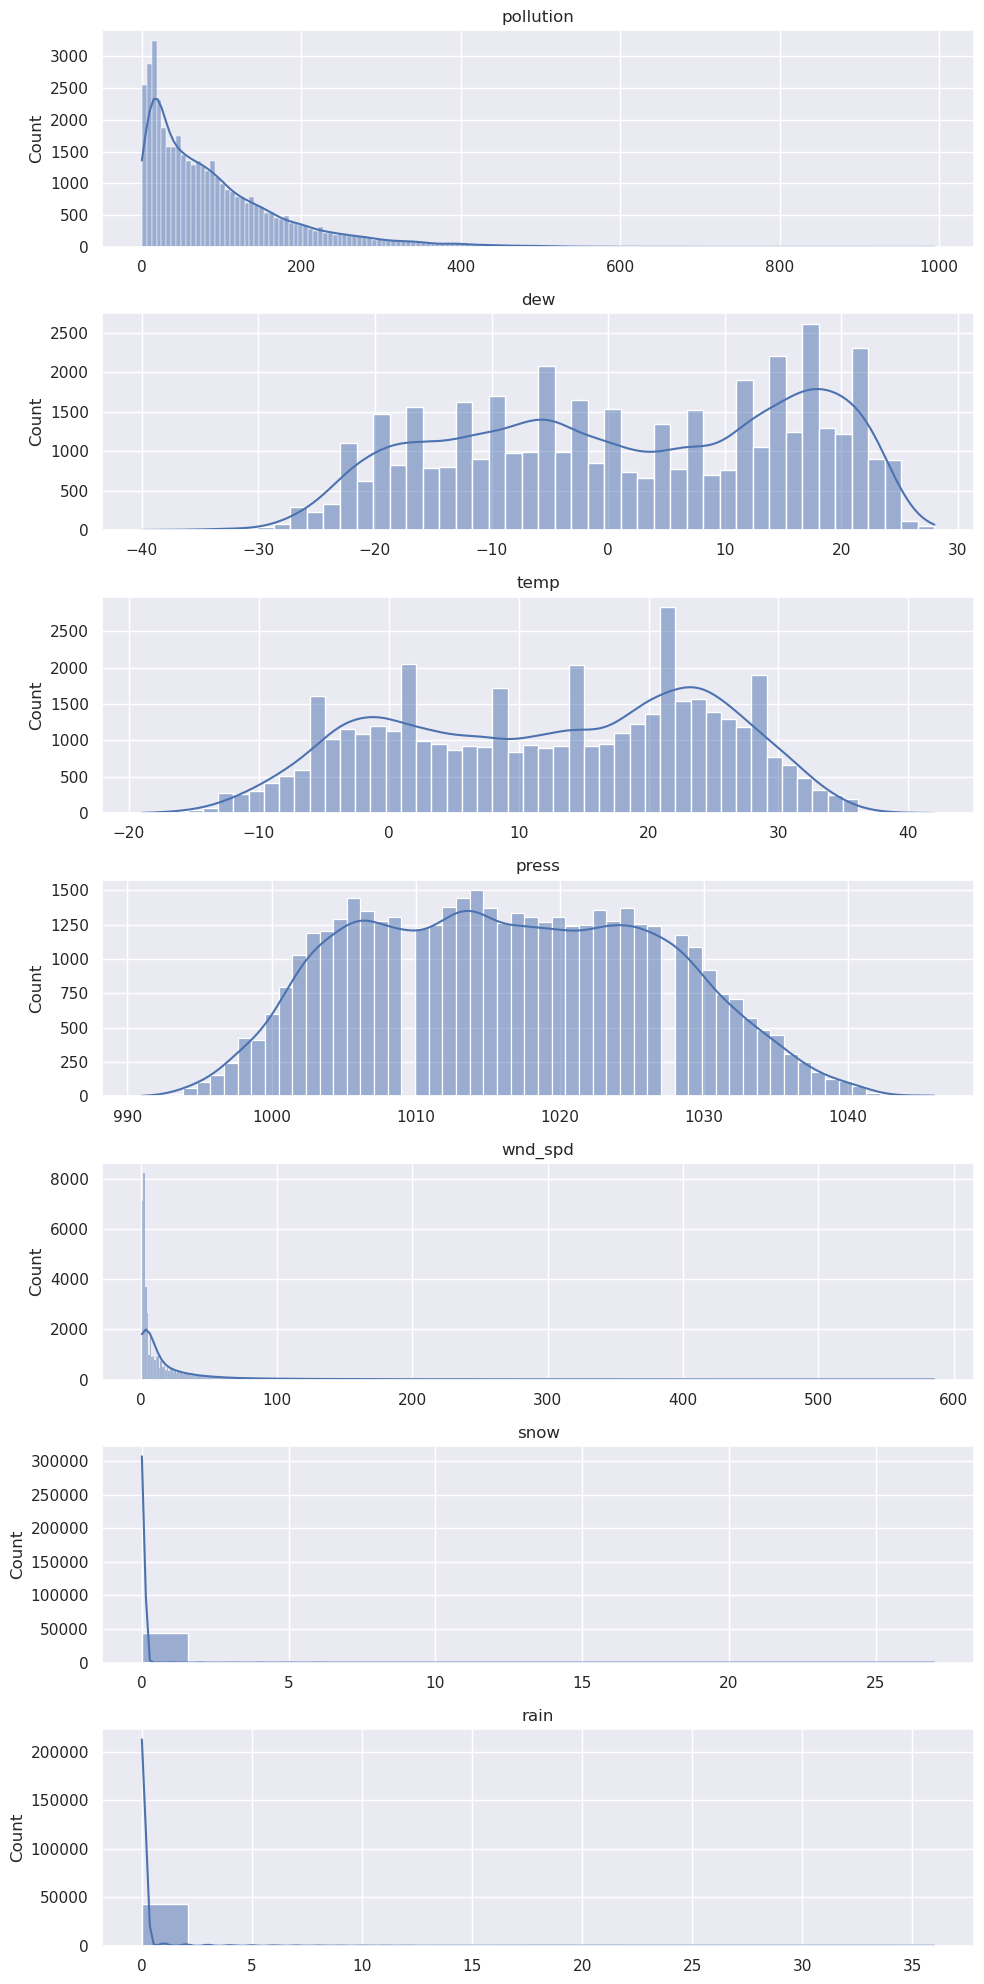

In [14]:
groups = [1, 2, 3, 4, 6, 7, 8]

# Create separate subplots for each boxplot
fig, axes = plt.subplots(7, 1, figsize=(10, 20))

for i in range(len(groups)):
    sn.histplot(pollution_df.values[:, groups[i]], ax=axes[i], kde=True)
    axes[i].set_title(pollution_df.columns[groups[i]])

plt.tight_layout()
plt.show()

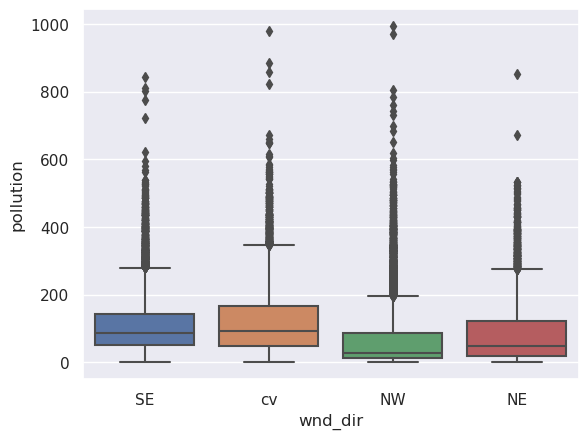

In [5]:
sn.boxplot(data=pollution_df, x="wnd_dir", y="pollution")
plt.show()

## Pytorch codes

### Custom dataset class

In [5]:
# Custom dataset class for pollution data
class PollutionData(Dataset):
    def __init__(self, X, y, seq_len, device=device):
        # Features and targets
        self.X = X
        self.y = y
        # Length of sequence
        self.seq_len = seq_len
        # Chosen device
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Concatenate X and y to use target lags as input
        X_sample = np.concatenate([self.X, self.y], axis=1)
        
        # If the index is lower than sequence length, then apply padding
        # The data used for prediction should reach until 24h before the prediction
        # It will make more sense to be able to predict the pollution 24h from now than 1h from now
        if idx >= self.seq_len:
            X_sample = X_sample[(idx - self.seq_len):idx]      
        else:
            X_sample = X_sample[:idx]
            padding = np.zeros((self.seq_len - idx, X_sample.shape[1]))
            X_sample = np.concatenate([padding, X_sample], axis = 0)
        
        return torch.tensor(X_sample).to(torch.float32).to(self.device), torch.tensor(self.y[idx]).to(torch.float32).to(self.device)

### Lightning dataloader

In [6]:
# Custom lightning dataloader
class PollutionDataLoader(pl.LightningDataModule):
    def __init__(self, train_dir, test_dir, seq_len, X_scaler, y_scaler, test_size, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.seq_len = seq_len
        self.X_scaler = X_scaler
        self.y_scaler = y_scaler
        self.test_size = test_size
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.train_df = None
        self.test_df = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.pollution_train = None
        self.pollution_val = None
        self.pollution_test = None

    def setup(self, stage):
        # Load the training dataset
        self.train_df = pd.read_csv(self.train_dir)
        # Load the test dataset
        self.test_df = pd.read_csv(self.test_dir)
        # Map the categories of wind direction to numeric values
        mapping = {"NE": 0, "NW": 1, "SE": 2, "cv": 3}
        self.train_df["wnd_dir"] = self.train_df.wnd_dir.map(mapping)
        self.test_df["wnd_dir"] = self.test_df.wnd_dir.map(mapping)
        # Create X and y by dropping date and seperating features and target
        X = self.train_df.drop(["date", "pollution"], axis=1)
        # Shift features by 24, because we want to predict pollution in 24h
        X = X.shift(periods=24, fill_value=0)
        y = self.train_df[["pollution"]]
        self.X_test = self.test_df.drop(["pollution"], axis=1)
        self.y_test = self.test_df[["pollution"]]
        # Apply train test split
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X
                                                                              , y
                                                                              , test_size=self.test_size
                                                                              , shuffle=False
                                                                              , random_state=self.random_sate
                                                                              )
        
        # Transform with scaler if provided
        if self.X_scaler and self.y_scaler:
            self.X_train = self.X_scaler.fit_transform(self.X_train)
            self.X_val = self.X_scaler.transform(self.X_val)
            self.X_test = self.X_scaler.transform(self.X_test)
            self.y_train = self.y_scaler.fit_transform(self.y_train)
            self.y_val = self.y_scaler.transform(self.y_val)
            self.y_test = self.y_scaler.transform(self.y_test)

        # Create two instances of the custom dataset class
        self.pollution_train = PollutionData(self.X_train
                                             , self.y_train
                                             , seq_len=self.seq_len
                                             , device=self.device
                                             )
        self.pollution_val = PollutionData(self.X_val
                                           , self.y_val
                                           , seq_len=self.seq_len
                                           , device=self.device
                                             )
        self.pollution_test = PollutionData(self.X_test
                                            , self.y_test
                                            , seq_len=self.seq_len
                                            , device=self.device
                                            )

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.pollution_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.pollution_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.pollution_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

### LSTM model class

In [7]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_size=self.input_size
                            , hidden_size=self.hidden_size
                            , num_layers=self.num_layers
                            , batch_first=True
                            , dropout=self.dropout_rate
                            )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.linear1(X[:,-1,:])
        X = self.relu(X)

        return X

### GRU model class

In [8]:
# GRU model class
class GRUModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.lstm = nn.GRU(input_size=self.input_size
                           , hidden_size=self.hidden_size
                           , num_layers=self.num_layers
                           , batch_first=True
                           , dropout=self.dropout_rate
                           )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features
                                 )
        self.relu = nn.ReLU()
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.linear1(X[:,-1,:])
        X = self.relu(X)

        return X

### PyTorch Lightning time-series model class

In [9]:
# Time-series model created with lightning
class TSModel(pl.LightningModule):
    def __init__(self, model, lr=0.01):
        super().__init__()
        # Model of choice (either LSTM or GRU)
        self.model = model
        # Learning rate
        self.lr = lr

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = F.mse_loss(y_pred, y)
        self.log("train_loss", train_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = F.mse_loss(y_pred, y)
        self.log("val_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        test_loss = F.mse_loss(y_pred, y)
        self.log("test_loss", test_loss, sync_dist=True)
    
    def predict_step(self, batch, batch_id):
        X, y = batch
        y_pred = self.model(X)

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Ray tuner

In [6]:
ray_epochs = 10

config = {
    "seq_len": tune.grid_search([24, 48])
    , "h_size": tune.grid_search([4, 8, 16, 32])
    , "num_l": tune.grid_search([4, 8, 16, 32])
    , "dropout_rate": tune.grid_search([0.2, 0.4])
    , "lr": tune.grid_search([1e-2, 1e-1])
    , "batch_size": tune.grid_search([64, 128, 256])
}

scheduler_asha = ASHAScheduler(
    max_t=10,
    grace_period=1,
    reduction_factor=2,
)

tune_report_callback = TuneReportCheckpointCallback(
    metrics={
    "val_loss": "val_loss"
    },
    filename="ray_ckpt",
    on="validation_end",
)

In [7]:
# Function for training model with Ray tuner
def model_train_func(config, max_epochs, model_type):
    enable_reproducibility(seed=42)
    
    dm = PollutionDataLoader(train_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/LSTM-Multivariate_pollution.csv"
                             , test_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/pollution_test_data1.csv"
                             , seq_len=config["seq_len"]
                             , X_scaler=MinMaxScaler()
                             , y_scaler=MinMaxScaler()
                             , test_size=0.3
                             , random_state=42
                             , batch_size=config["batch_size"]
                             , num_workers=0
                             , device=device
                             )
    
    if model_type == "LSTM":
        torch_model = LSTMModel(in_size=8
                                , h_size=config["h_size"]
                                , num_l=config["num_l"]
                                , out_f=1
                                , dropout_rate=config['dropout_rate']).to(device)
    else:
        torch_model = GRUModel(in_size=8
                               , h_size=config["h_size"]
                               , num_l=config["num_l"]
                               , out_f=1
                               , dropout_rate=config['dropout_rate']).to(device)
            
    model = TSModel(torch_model, lr=config['lr'])

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=False,
        callbacks=[
            tune_report_callback,
        ],
    )

    trainer.fit(model, datamodule=dm)

#### LSTM

In [11]:
# LSTM hyperparameter tuning
pl.seed_everything(42, workers=True)

lstm_search_results = tune.run(
    tune.with_parameters(
        model_train_func
        , max_epochs=ray_epochs
        , model_type="LSTM"
        )
        , metric="val_loss"
        , mode="min"
        , config=config
        , num_samples=1
        , scheduler=scheduler_asha
        , max_concurrent_trials=2
)

Seed set to 42
2023-11-28 00:39:23,586	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-11-28 00:39:27,893	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-11-28 00:39:27,896	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-11-28 00:39:27,951	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-11-28 00:39:27,952	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(model_train_func pid=89469) GPU available: False, used: False
(model_train_func pid=89469) TPU available: False, using: 0 TPU cores
(model_train_func pid=89469) IPU available: False, using: 0 IPUs
(model_train_func pid=89469) HPU available: False, using: 0 HPUs
(model_train_func pid=89469) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
(model_train_func pid=89469) Missing logger folder: /home/maciej/ray_results/model_train_func_2023-11-28_00-39-27/model_train_func_34650_00000_0_batch_size

Trial name,should_checkpoint,val_loss
model_train_func_34650_00000,True,0.016813
model_train_func_34650_00001,True,0.016813
model_train_func_34650_00002,True,0.016813
model_train_func_34650_00003,True,0.016813
model_train_func_34650_00004,True,0.016813
model_train_func_34650_00005,True,0.016813
model_train_func_34650_00006,True,0.000547444
model_train_func_34650_00007,True,0.000584774
model_train_func_34650_00008,True,0.00058447
model_train_func_34650_00009,True,0.000690413


(model_train_func pid=89472) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/model_train_func_2023-11-28_00-39-27/model_train_func_34650_00001_1_batch_size=128,dropout_rate=0.2000,h_size=4,lr=0.0100,num_l=4,seq_len=24_2023-11-28_00-39-28/checkpoint_000000)
(model_train_func pid=89472) GPU available: False, used: False
(model_train_func pid=89472) TPU available: False, using: 0 TPU cores
(model_train_func pid=89472) IPU available: False, using: 0 IPUs
(model_train_func pid=89472) HPU available: False, using: 0 HPUs
(model_train_func pid=89472) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless t

In [12]:
lstm_search_results.best_result

{'val_loss': 0.0005335013847798109,
 'timestamp': 1701140767,
 'checkpoint_dir_name': 'checkpoint_000009',
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 10,
 'trial_id': '34650_00212',
 'date': '2023-11-28_04-06-07',
 'time_this_iter_s': 34.73401737213135,
 'time_total_s': 350.0762867927551,
 'pid': 89472,
 'hostname': 'maciej-ThinkPad-T480',
 'node_ip': '192.168.1.17',
 'config': {'seq_len': 48,
  'h_size': 32,
  'num_l': 4,
  'dropout_rate': 0.2,
  'lr': 0.01,
  'batch_size': 256},
 'time_since_restore': 350.0762867927551,
 'iterations_since_restore': 10,
 'experiment_tag': '212_batch_size=256,dropout_rate=0.2000,h_size=32,lr=0.0100,num_l=4,seq_len=48'}

#### GRU

In [8]:
# GRU hyperparameter tuning
pl.seed_everything(42, workers=True)

gru_search_results = tune.run(
    tune.with_parameters(
        model_train_func
        , max_epochs=ray_epochs
        , model_type="GRU"
        )
        , metric="val_loss"
        , mode="min"
        , config=config
        , num_samples=1
        , scheduler=scheduler_asha
        , max_concurrent_trials=2
        , max_failures=-1
        # , resume=True
)

Seed set to 42
2023-11-30 00:29:24,132	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-11-30 00:29:28,352	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-11-30 00:29:28,355	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-11-30 00:29:28,384	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-11-30 00:29:28,385	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(model_train_func pid=195787) GPU available: False, used: False
(model_train_func pid=195787) TPU available: False, using: 0 TPU cores
(model_train_func pid=195787) IPU available: False, using: 0 IPUs
(model_train_func pid=195787) HPU available: False, using: 0 HPUs
(model_train_func pid=195787) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
(model_train_func pid=195787) Missing logger folder: /home/maciej/ray_results/model_train_func_2023-11-30_00-29-28/model_train_func_23d9f_00001_1_batc

Trial name,should_checkpoint,val_loss
model_train_func_23d9f_00000,True,0.000674552
model_train_func_23d9f_00001,True,0.000620753
model_train_func_23d9f_00002,True,0.00159272
model_train_func_23d9f_00003,True,0.000759849
model_train_func_23d9f_00004,True,0.00110693
model_train_func_23d9f_00005,True,0.00173302
model_train_func_23d9f_00006,True,0.016813
model_train_func_23d9f_00007,True,0.016813
model_train_func_23d9f_00008,True,0.016813
model_train_func_23d9f_00009,True,0.016813


(model_train_func pid=195787) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/model_train_func_2023-11-30_00-29-28/model_train_func_23d9f_00001_1_batch_size=128,dropout_rate=0.2000,h_size=4,lr=0.0100,num_l=4,seq_len=24_2023-11-30_00-29-28/checkpoint_000000)
(model_train_func pid=195786) GPU available: False, used: False
(model_train_func pid=195786) TPU available: False, using: 0 TPU cores
(model_train_func pid=195786) IPU available: False, using: 0 IPUs
(model_train_func pid=195786) HPU available: False, using: 0 HPUs
(model_train_func pid=195786) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, un

In [9]:
gru_search_results.best_result

{'val_loss': 0.0005310196429491043,
 'timestamp': 1701301151,
 'checkpoint_dir_name': 'checkpoint_000009',
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 10,
 'trial_id': '23d9f_00013',
 'date': '2023-11-30_00-39-11',
 'time_this_iter_s': 21.349647521972656,
 'time_total_s': 234.9894380569458,
 'pid': 195787,
 'hostname': 'maciej-ThinkPad-T480',
 'node_ip': '192.168.1.17',
 'config': {'seq_len': 24,
  'h_size': 16,
  'num_l': 4,
  'dropout_rate': 0.2,
  'lr': 0.01,
  'batch_size': 128},
 'time_since_restore': 234.9894380569458,
 'iterations_since_restore': 10,
 'experiment_tag': '13_batch_size=128,dropout_rate=0.2000,h_size=16,lr=0.0100,num_l=4,seq_len=24'}

### Training loop

In [17]:
# Creating the lightning data loader
pollution_loader = PollutionDataLoader(train_dir="data/LSTM-Multivariate_pollution.csv"
                                       , test_dir="data/pollution_test_data1.csv"
                                       , seq_len=48
                                       , X_scaler=MinMaxScaler()
                                       , y_scaler=MinMaxScaler()
                                       , test_size=0.3
                                       , random_state=42
                                       , batch_size=256
                                       , num_workers=7
                                       , device=device
                                       )

# GRU gets a seperate one
gru_loader = PollutionDataLoader(train_dir="data/LSTM-Multivariate_pollution.csv"
                                 , test_dir="data/pollution_test_data1.csv"
                                 , seq_len=24
                                 , X_scaler=MinMaxScaler()
                                 , y_scaler=MinMaxScaler()
                                 , test_size=0.3
                                 , random_state=42
                                 , batch_size=128
                                 , num_workers=7
                                 , device=device
                                 )

#### LSTM

In [36]:
pl.seed_everything(42, workers=True)
lstm_model = LSTMModel(in_size=8, h_size=32, num_l=4, out_f=1, dropout_rate=0.2).to(device)
lstm_ts_model = TSModel(lstm_model, lr=0.01)
# If there's no improvement in validation loss after 3 epochs than apply early stopping
lstm_trainer = pl.Trainer(max_epochs=20, enable_checkpointing=True
                          , callbacks=[EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00005, patience=3, verbose=False, check_on_train_epoch_end=False)]
                          )
lstm_trainer.fit(lstm_ts_model, datamodule=pollution_loader)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 30.8 K
------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

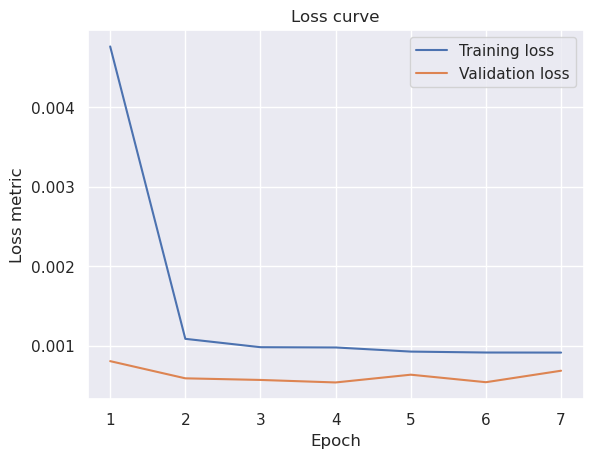

In [37]:
plot_loss_curve()

#### GRU

In [38]:
pl.seed_everything(42, workers=True)
gru_model = GRUModel(in_size=8, h_size=16, num_l=4, out_f=1, dropout_rate=0.2).to(device)
gru_ts_model = TSModel(gru_model, lr=0.01)

gru_trainer = pl.Trainer(max_epochs=20, enable_checkpointing=True
                         , callbacks=[EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00005, patience=3, verbose=False, check_on_train_epoch_end=False)]
                         )
gru_trainer.fit(gru_ts_model, datamodule=gru_loader)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GRUModel | 6.2 K 
-----------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

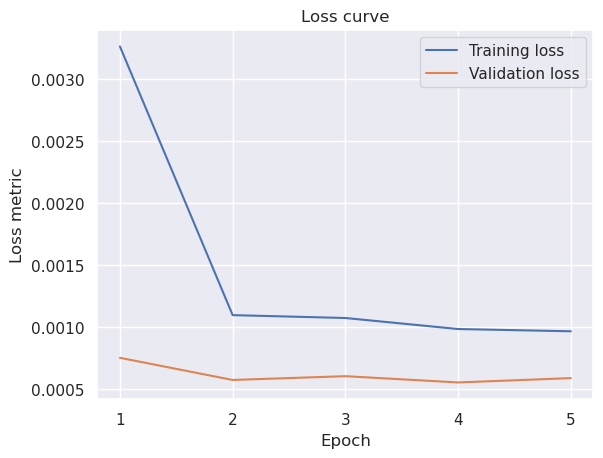

In [39]:
plot_loss_curve()

#### Prediction

In [40]:
def get_predictions(model, trainer, loader):
    preds = trainer.predict(model, dataloaders=loader.test_dataloader())
    preds = loader.y_scaler.inverse_transform(torch.cat(preds))

    return preds

def evaluate_pred(model, trainer, loader):
    preds = get_predictions(model, trainer, loader)
    mse_val = mean_squared_error(pollution_test_df['pollution'], preds)
    mae_val = mean_absolute_error(pollution_test_df['pollution'], preds)
    mape_val = mean_absolute_percentage_error(pollution_test_df['pollution'].map(lambda x: x+0.1), preds)

    return mse_val, mae_val, mape_val

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

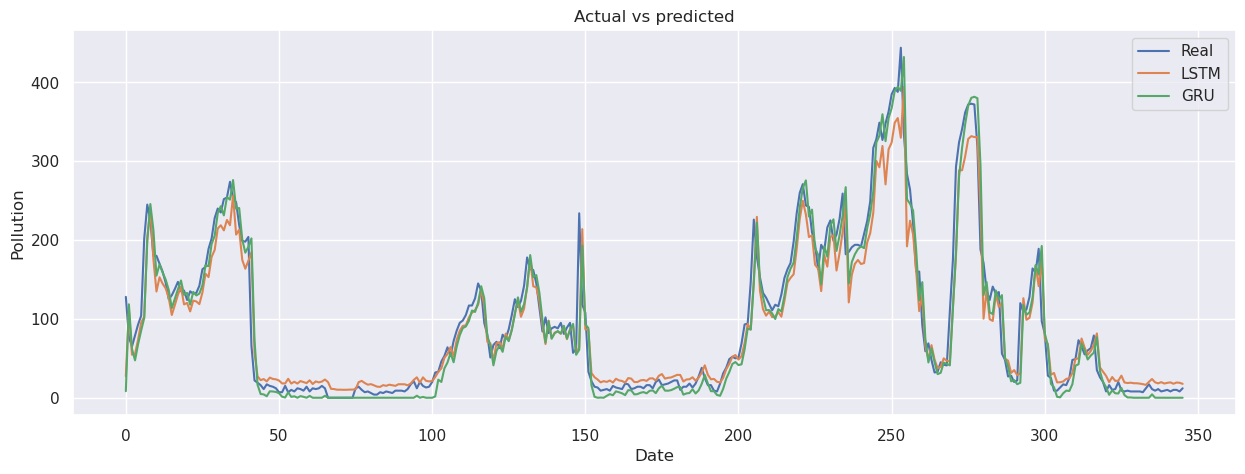

In [41]:
plt.figure(figsize=(15,5))
plt.ylabel("Pollution")
plt.xlabel("Date")
plt.plot(pollution_test_df['pollution'], label="Real")
plt.plot(get_predictions(lstm_ts_model, lstm_trainer, pollution_loader), label="LSTM")
plt.plot(get_predictions(gru_ts_model, gru_trainer, gru_loader), label="GRU")
plt.title("Actual vs predicted")
plt.legend()
plt.show()

### Compare models

In [42]:
lstm_mse_val, lstm_mae_val, lstm_mape_val = evaluate_pred(lstm_ts_model, lstm_trainer, pollution_loader)
gru_mse_val, gru_mae_val, gru_mape_val = evaluate_pred(gru_ts_model, gru_trainer, gru_loader)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

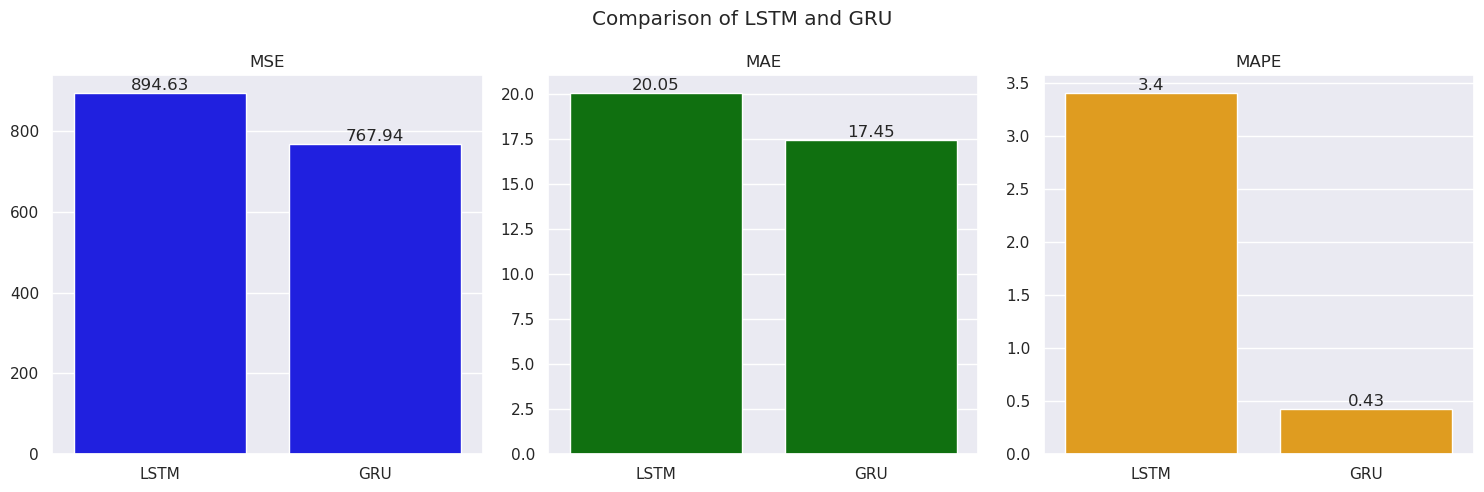

In [43]:
model_names = ["LSTM", "GRU"]
mse_values = [lstm_mse_val, gru_mse_val]
mae_values = [lstm_mae_val, gru_mae_val]
mape_values = [lstm_mape_val, gru_mape_val]

# Create separate subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MSE subplot
mse_bars = sn.barplot(x=model_names, y=mse_values, ax=axes[0], color="blue")
axes[0].set_title("MSE")

# Annotate
for bar, val in zip(mse_bars.patches, mse_values):
    mse_bars.annotate(f'{round(val, 2)}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

# MAE subplot
mae_bars = sn.barplot(x=model_names, y=mae_values, ax=axes[1], color="green")
axes[1].set_title("MAE")

# Annotate
for bar, val in zip(mae_bars.patches, mae_values):
    mae_bars.annotate(f'{round(val, 2)}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

# MAPE subplot
mape_bars = sn.barplot(x=model_names, y=mape_values, ax=axes[2], color="orange")
axes[2].set_title("MAPE")

# Annotate
for bar, val in zip(mape_bars.patches, mape_values):
    mape_bars.annotate(f'{round(val, 2)}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

plt.suptitle("Comparison of LSTM and GRU")
plt.tight_layout()
plt.show()